In [3]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


# Đọc dữ liệu
try:
    df = pd.read_csv('GIS_DataAQI.csv')
except FileNotFoundError:
    print("Lỗi: File 'GIS_DataAQI.csv' không tìm thấy. Hãy đảm bảo file nằm đúng thư mục.")
    exit()

print(f"Dữ liệu gốc có {df.shape[0]} dòng và {df.shape[1]} cột.")

# --- Xử lý giá trị thiếu và không hợp lệ ---
df.replace('N/A', np.nan, inplace=True)
df.replace('-', np.nan, inplace=True)

numeric_cols = ['aqi', 'pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 
                'humidity', 'temperature', 'wind', 'population', 'area']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nKiểm tra các giá trị nhiệt độ và gió bất thường (ví dụ):")
print(df[df['name'] == 'Gia Lai'][['name', 'temperature', 'wind']].head())

# --- Xử lý giá trị ngoại lệ (Outliers) bằng Clipping ---
cols_to_clip = ['aqi', 'pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 'humidity', 'temperature', 'wind']
print("\\nBắt đầu xử lý outliers bằng clipping...")
for col in cols_to_clip:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        lower_bound = df[col].quantile(0.01)
        upper_bound = df[col].quantile(0.99)
        if pd.notna(lower_bound) and pd.notna(upper_bound):
            original_nan_count = df[col].isna().sum()
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            if df[col].isna().sum() > original_nan_count:
                 print(f"Cảnh báo: Clipping có thể đã tạo thêm NaN trong cột {col}")
        else:
            print(f"Bỏ qua clipping cho cột {col} do không tính được quantile (có thể do quá nhiều NaN).")
print("Xử lý outliers hoàn tất.")


print("\\nKiểm tra lại giá trị nhiệt độ và gió sau clipping (ví dụ):")
print(df[df['name'] == 'Gia Lai'][['name', 'temperature', 'wind']].head())

# --- Xử lý ngày tháng ---
df['update_time'] = pd.to_datetime(df['update_time'], errors='coerce')
try:
    df['saved_at'] = pd.to_datetime(df['saved_at'], format='%H:%M %d/%m/%Y', errors='coerce')
except ValueError:
    df['saved_at'] = pd.to_datetime(df['saved_at'], errors='coerce')

initial_rows = df.shape[0]
df.dropna(subset=['aqi'], inplace=True)
print(f"\nĐã loại bỏ {initial_rows - df.shape[0]} dòng do thiếu giá trị 'aqi'.")

df['region'] = np.where(df['country'] == 'Vietnam', 'Vietnam', 'Denmark')

ModuleNotFoundError: No module named 'xgboost'

In [16]:
# --- Tạo biến mục tiêu: Mức độ rủi ro sức khỏe (Health Risk) ---
def aqi_to_risk(aqi):
    if pd.isna(aqi):
        return np.nan 
    try:
       aqi = float(aqi)
    except ValueError:
        return np.nan
        
    if aqi <= 50:
        return 0
    elif aqi <= 100:
        return 1
    elif aqi <= 150:
        return 2
    elif aqi <= 200:
        return 3
    elif aqi <= 300:
        return 4
    else:
        return 5

df['health_risk'] = df['aqi'].apply(aqi_to_risk)

print("\nPhân phối các mức độ rủi ro sức khỏe (biến mục tiêu):")
print(df['health_risk'].value_counts(dropna=False).sort_index())

# --- Tạo các đặc trưng khác (Tùy chọn, có thể dùng cho phân tích hoặc mô hình khác) ---
df['population_density'] = df['population'] / df['area']
if df['population_density'].isna().sum() / len(df) > 0.5:
    print("\nCảnh báo: Thiếu nhiều dữ liệu (>50%) cho 'population' và/hoặc 'area'. Đặc trưng 'population_density' sẽ có nhiều giá trị NaN.")

pm25_thresholds = [0, 12.1, 35.5, 55.5, 150.5, 250.5, 500.5]
pm10_thresholds = [0, 55, 155, 255, 355, 425, 605]
no2_thresholds = [0, 54, 101, 361, 650, 1250, 2050]
so2_thresholds = [0, 36, 76, 186, 305, 605, 1005]
o3_thresholds_8hr = [0, 55, 71, 86, 106, 201]

def categorize_pollutant(value, thresholds):
    if pd.isna(value):
        return np.nan
    try:
       value = float(value)
    except ValueError:
        return np.nan
    for i, threshold in enumerate(thresholds[1:], 1):
        if value < threshold:
            return i - 1
    return len(thresholds) - 2

df['pm25_level'] = df['pm25'].apply(lambda x: categorize_pollutant(x, pm25_thresholds))
df['pm10_level'] = df['pm10'].apply(lambda x: categorize_pollutant(x, pm10_thresholds))
df['no2_level'] = df['no2'].apply(lambda x: categorize_pollutant(x, no2_thresholds))
df['so2_level'] = df['so2'].apply(lambda x: categorize_pollutant(x, so2_thresholds))
df['o3_level'] = df['o3'].apply(lambda x: categorize_pollutant(x, o3_thresholds_8hr))


Phân phối các mức độ rủi ro sức khỏe (biến mục tiêu):
health_risk
0    912
1    364
2    114
3     34
Name: count, dtype: int64



Thống kê mô tả cơ bản cho các cột số:
               aqi         pm25         pm10         no2          co  \
count  1424.000000  1229.000000  1307.000000  960.000000  894.000000   
mean     44.956847    46.460667    32.708493   17.079687    3.343065   
std      37.178753    39.000202    26.085763   29.211806    4.574805   
min       1.000000     1.000000     0.000000    0.000000    0.000000   
25%      16.000000    14.000000    10.500000    1.400000    0.000000   
50%      35.000000    37.000000    27.000000    5.000000    1.700000   
75%      62.000000    68.000000    51.000000   14.000000    5.000000   
max     158.770000   161.940000   112.000000  113.000000   22.000000   

               o3         so2    humidity  temperature        wind  \
count  924.000000  804.000000  672.000000   711.000000  693.000000   
mean    12.472446   12.796517   76.832679    20.431505    5.103319   
std     10.059817   19.369626   13.911136    12.272619   10.677858   
min      1.000000    0.000000   

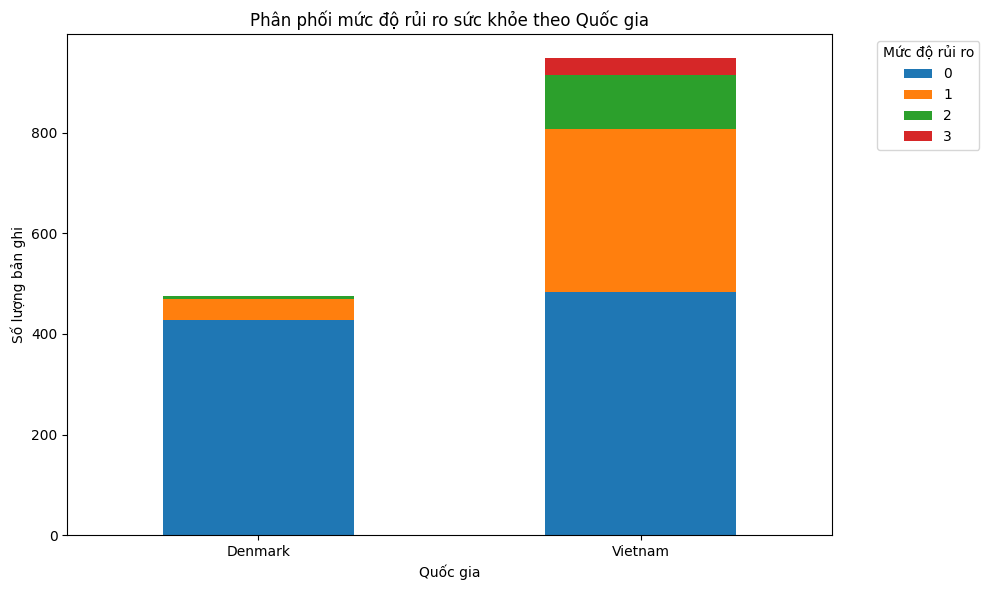


10 Thành phố/Địa điểm có AQI cao nhất (ô nhiễm nhất):
             name  country     aqi         update_time
531   Thái Nguyên  Vietnam  158.77 2025-04-08 23:00:00
392   Thái Nguyên  Vietnam  158.77 2025-04-08 14:00:00
480   Thái Nguyên  Vietnam  158.77 2025-04-08 18:00:00
58    Thái Nguyên  Vietnam  158.77 2025-04-06 20:00:00
439   Thái Nguyên  Vietnam  158.77 2025-04-08 16:00:00
1024  Thái Nguyên  Vietnam  158.77 2025-04-12 02:00:00
269     Bắc Giang  Vietnam  158.77 2025-04-07 20:00:00
1050       Hà Nội  Vietnam  158.77 2025-04-12 17:00:00
13         Hà Nội  Vietnam  158.77 2025-04-06 14:00:00
15    Thái Nguyên  Vietnam  158.77 2025-04-06 14:00:00

10 Thành phố/Địa điểm có AQI thấp nhất (sạch nhất, AQI > 0):
                          name  country  aqi         update_time
28          Hedevej, Frederiks  Denmark  1.0 2025-04-06 08:35:01
30    Møllebjergvej, Rudkøbing  Denmark  1.0 2025-04-06 08:34:06
1274            Vardevej, Tarm  Denmark  1.0 2025-04-12 20:05:26
38              Va

In [17]:
# Thống kê cơ bản cho các cột số
print("\nThống kê mô tả cơ bản cho các cột số:")
print(df[numeric_cols + ['health_risk']].describe())

# Thống kê cơ bản theo quốc gia
print("\nGiá trị trung bình các chỉ số theo quốc gia:")
stats_by_country = df.groupby('country')[numeric_cols].mean()
print(stats_by_country)

# Tính tỷ lệ các mức rủi ro sức khỏe theo quốc gia
print("\nPhân phối mức độ rủi ro theo quốc gia:")
risk_distribution = df.groupby(['country', 'health_risk']).size().unstack(fill_value=0)
print(risk_distribution)
risk_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Phân phối mức độ rủi ro sức khỏe theo Quốc gia')
plt.xlabel('Quốc gia')
plt.ylabel('Số lượng bản ghi')
plt.xticks(rotation=0)
plt.legend(title='Mức độ rủi ro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Tìm thành phố có mức ô nhiễm cao nhất và thấp nhất (dựa trên AQI)
worst_cities = df.sort_values('aqi', ascending=False).head(10)
best_cities = df[df['aqi'] > 0].sort_values('aqi').head(10)

print("\n10 Thành phố/Địa điểm có AQI cao nhất (ô nhiễm nhất):")
print(worst_cities[['name', 'country', 'aqi', 'update_time']])

print("\n10 Thành phố/Địa điểm có AQI thấp nhất (sạch nhất, AQI > 0):")
print(best_cities[['name', 'country', 'aqi', 'update_time']])

# --- 4.1. Chuẩn bị dữ liệu cho mô hình ---


In [18]:
# Chọn các đặc trưng (features) và biến mục tiêu (target)
features = ['pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 'humidity', 'temperature', 'wind']
target = 'health_risk'

X = df[features].copy()
y = df[target].copy()

# --- QUAN TRỌNG: Xử lý NaN và các lớp không có trong dữ liệu ---
valid_rows_y = y.notna()
y = y[valid_rows_y]
X = X[valid_rows_y]

available_classes = sorted(y.unique())
num_available_classes = len(available_classes)
print(f"Các lớp rủi ro có trong dữ liệu: {available_classes}")
if num_available_classes < 6:
    print(f"CẢNH BÁO: Dữ liệu thiếu các lớp rủi ro {[c for c in range(6) if c not in available_classes]}. Mô hình sẽ không thể dự đoán các lớp này.")

rows_before_nan_drop = X.shape[0]

print(f"\nSố lượng mẫu dùng để huấn luyện/kiểm tra: {X.shape[0]}")
print("Phân phối lớp trước khi chia:")
print(y.value_counts(normalize=True).sort_index())


try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
except ValueError as e:
    print(f"\nLỗi khi chia dữ liệu (có thể do số lượng mẫu quá ít cho một lớp): {e}")
    print("Thử chia không dùng stratify (ít được khuyến nghị hơn nếu các lớp mất cân bằng):")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"\nKích thước tập huấn luyện: {X_train.shape[0]} mẫu")
print(f"Kích thước tập kiểm tra: {X_test.shape[0]} mẫu")
print("\nPhân phối lớp trong tập huấn luyện:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nPhân phối lớp trong tập kiểm tra:")
print(y_test.value_counts(normalize=True).sort_index())


# --- Định nghĩa Pipeline Tiền xử lý ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features)
    ],
    remainder='passthrough'
)

# --- Định nghĩa SMOTE ---
min_class_count = y_train.value_counts().min()
smote_k_neighbors = max(1, min(5, min_class_count - 1))
if min_class_count > 1:
    smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
    print(f"\nSử dụng SMOTE với k_neighbors={smote_k_neighbors}")
else:
    smote = None
    print("\nCảnh báo: Lớp thiểu số có quá ít mẫu (<=1), không thể áp dụng SMOTE.")


Các lớp rủi ro có trong dữ liệu: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
CẢNH BÁO: Dữ liệu thiếu các lớp rủi ro [4, 5]. Mô hình sẽ không thể dự đoán các lớp này.

Số lượng mẫu dùng để huấn luyện/kiểm tra: 1424
Phân phối lớp trước khi chia:
health_risk
0    0.640449
1    0.255618
2    0.080056
3    0.023876
Name: proportion, dtype: float64

Kích thước tập huấn luyện: 1068 mẫu
Kích thước tập kiểm tra: 356 mẫu

Phân phối lớp trong tập huấn luyện:
health_risk
0    0.640449
1    0.255618
2    0.079588
3    0.024345
Name: proportion, dtype: float64

Phân phối lớp trong tập kiểm tra:
health_risk
0    0.640449
1    0.255618
2    0.081461
3    0.022472
Name: proportion, dtype: float64

Sử dụng SMOTE với k_neighbors=5


# --- 4.2. Định nghĩa, Huấn luyện và Đánh giá các Mô hình ---


In [19]:
# Định nghĩa các mô hình
models = {
    "Logistic Regression": LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced', max_depth=10, min_samples_leaf=3),
    "SVC": SVC(probability=True, random_state=42, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(
                    objective='multi:softmax',
                    num_class=num_available_classes,
                    n_estimators=150,
                    learning_rate=0.1,
                    max_depth=4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    random_state=42,
                    early_stopping_rounds=10
                 )
}

# Tạo và đánh giá pipelines bằng Cross-Validation
results = {}
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Chỉ số đánh giá chính: F1 Macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

print("\n--- Bắt đầu đánh giá mô hình bằng Cross-Validation (5 folds) ---")

for name, model in models.items():
    print(f"\nĐánh giá mô hình: {name}")

    steps = [('preprocessor', preprocessor)]
    if smote:
        steps.append(('smote', smote))
    steps.append(('classifier', model))

    pipeline = ImbPipeline(steps=steps)

    if name == "XGBoost":
         xgb_model_for_cv = xgb.XGBClassifier(
             objective='multi:softmax',
             num_class=num_available_classes,
             n_estimators=150,
             learning_rate=0.1,
             max_depth=4,
             subsample=0.8,
             colsample_bytree=0.8,
             use_label_encoder=False,
             eval_metric='mlogloss',
             random_state=42
         )
         steps_cv = [('preprocessor', preprocessor)]
         if smote:
             steps_cv.append(('smote', smote))
         steps_cv.append(('classifier', xgb_model_for_cv))
         pipeline_cv = ImbPipeline(steps=steps_cv)

         try:
             cv_scores = cross_val_score(pipeline_cv, X_train, y_train, cv=cv_splitter, scoring=f1_macro_scorer)
             results[name] = cv_scores
             print(f"  CV F1 Macro Scores: {cv_scores}")
             print(f"  CV F1 Macro Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
         except Exception as e:
             print(f"  Lỗi khi thực hiện CV cho {name}: {e}")
             results[name] = np.array([np.nan] * cv_splitter.get_n_splits())
    else:
        try:
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_splitter, scoring=f1_macro_scorer)
            results[name] = cv_scores
            print(f"  CV F1 Macro Scores: {cv_scores}")
            print(f"  CV F1 Macro Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        except Exception as e:
             print(f"  Lỗi khi thực hiện CV cho {name}: {e}")
             results[name] = np.array([np.nan] * cv_splitter.get_n_splits())


# --- So sánh kết quả CV ---
print("\n--- So sánh kết quả Cross-Validation (F1 Macro Mean) ---")
mean_scores = {name: np.nanmean(scores) for name, scores in results.items()}
best_model_name = max(mean_scores, key=lambda k: mean_scores[k] if not np.isnan(mean_scores[k]) else -1)

for name, score in sorted(mean_scores.items(), key=lambda item: item[1], reverse=True):
     print(f"  {name}: {score:.4f}")

print(f"\n=> Mô hình tốt nhất dựa trên CV F1 Macro Mean: {best_model_name}")



--- Bắt đầu đánh giá mô hình bằng Cross-Validation (5 folds) ---

Đánh giá mô hình: Logistic Regression


c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning

  CV F1 Macro Scores: [0.97204274 0.96542989 0.93119819 0.91264967 0.89378626]
  CV F1 Macro Mean: 0.9350 (+/- 0.0300)

Đánh giá mô hình: Random Forest
  CV F1 Macro Scores: [0.98088478 0.97146464 0.97830787 0.96451077 0.98731176]
  CV F1 Macro Mean: 0.9765 (+/- 0.0079)

Đánh giá mô hình: SVC
  CV F1 Macro Scores: [0.94921543 0.92795526 0.88112659 0.88107711 0.90476827]
  CV F1 Macro Mean: 0.9088 (+/- 0.0266)

Đánh giá mô hình: XGBoost


c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:14:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:14:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:14:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:14:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_en

  CV F1 Macro Scores: [0.98704421 0.99369748 0.96938002 0.94567818 0.9602304 ]
  CV F1 Macro Mean: 0.9712 (+/- 0.0175)

--- So sánh kết quả Cross-Validation (F1 Macro Mean) ---
  Random Forest: 0.9765
  XGBoost: 0.9712
  Logistic Regression: 0.9350
  SVC: 0.9088

=> Mô hình tốt nhất dựa trên CV F1 Macro Mean: Random Forest


# --- 4.3. Huấn luyện Mô hình Tốt nhất và Lưu Pipeline ---



--- Huấn luyện mô hình tốt nhất (Random Forest) trên toàn bộ tập huấn luyện ---
Huấn luyện Random Forest...
Huấn luyện hoàn tất.

--- Đánh giá mô hình tốt nhất (Random Forest) trên tập kiểm tra (Test Set) ---
Classification Report trên Test Set:
              precision    recall  f1-score   support

       Mức 0       1.00      0.99      0.99       228
       Mức 1       0.97      1.00      0.98        91
       Mức 2       1.00      1.00      1.00        29
       Mức 3       1.00      1.00      1.00         8

    accuracy                           0.99       356
   macro avg       0.99      1.00      0.99       356
weighted avg       0.99      0.99      0.99       356



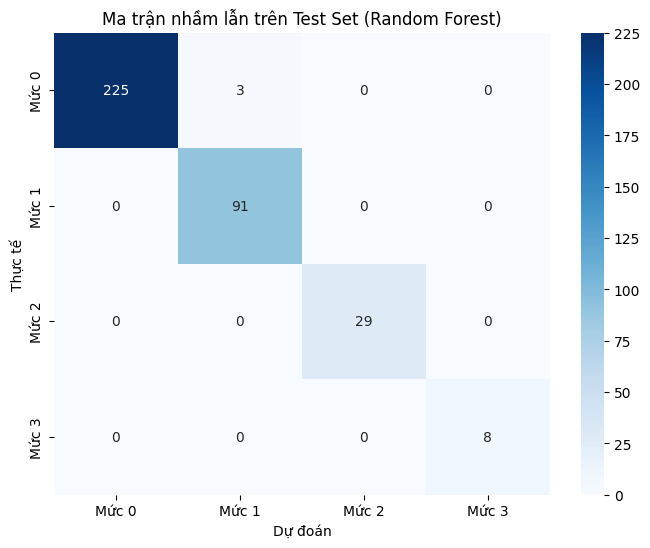


Lưu pipeline hoàn chỉnh đã huấn luyện vào file: health_risk_pipeline.pkl
Lưu hoàn tất.


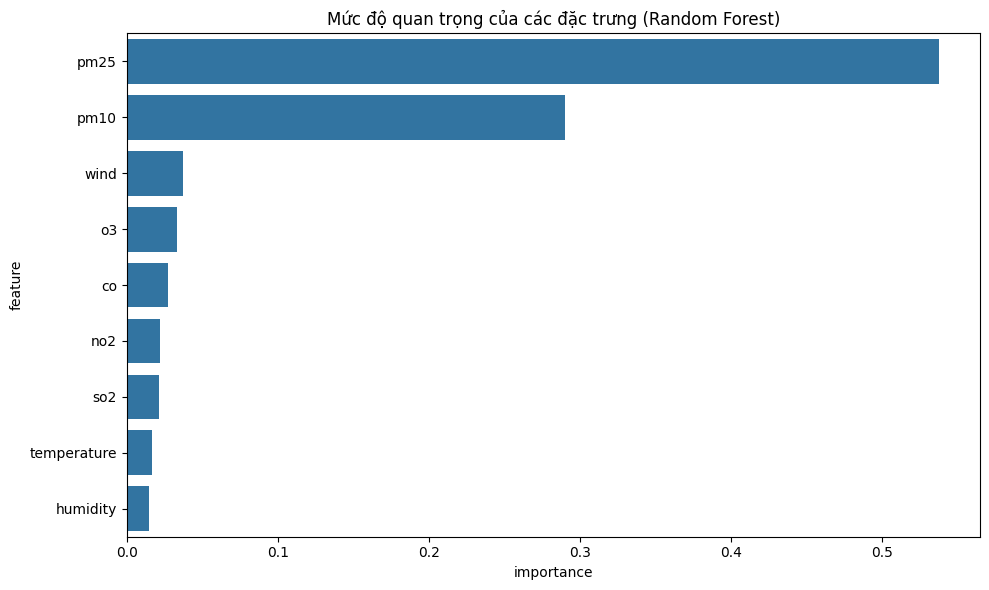

In [20]:
print(f"\n--- Huấn luyện mô hình tốt nhất ({best_model_name}) trên toàn bộ tập huấn luyện ---")

best_model_definition = models[best_model_name]

final_steps = [('preprocessor', preprocessor)]
if smote:
    final_steps.append(('smote', smote))
final_steps.append(('classifier', best_model_definition))

final_pipeline = ImbPipeline(steps=final_steps)

if best_model_name == "XGBoost":
    print("Huấn luyện XGBoost với Early Stopping...")
    X_train_final_proc = preprocessor.fit_transform(X_train)
    X_test_final_proc = preprocessor.transform(X_test)

    if smote:
         X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final_proc, y_train)
         print(f"Kích thước tập huấn luyện sau SMOTE: {X_train_resampled.shape}")
    else:
         X_train_resampled, y_train_resampled = X_train_final_proc, y_train

    eval_set = [(X_test_final_proc, y_test)]
    final_model_only = best_model_definition
    final_model_only.fit(X_train_resampled, y_train_resampled,
                         eval_set=eval_set,
                         verbose=False)

    final_pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', final_model_only)
    ])
    final_pipeline_xgb.named_steps['preprocessor'].fit(X_train)
    final_pipeline_to_save = final_pipeline_xgb

else:
    print(f"Huấn luyện {best_model_name}...")
    final_pipeline.fit(X_train, y_train)
    final_pipeline_to_save = final_pipeline

print("Huấn luyện hoàn tất.")


# --- Đánh giá cuối cùng trên tập Test ---
print(f"\n--- Đánh giá mô hình tốt nhất ({best_model_name}) trên tập kiểm tra (Test Set) ---")
y_pred_test = final_pipeline_to_save.predict(X_test)

print("Classification Report trên Test Set:")
report_labels = sorted(np.unique(np.concatenate((y_test, y_pred_test))))
print(classification_report(y_test, y_pred_test, labels=report_labels, target_names=[f"Mức {l}" for l in report_labels], zero_division=0))

cm_test = confusion_matrix(y_test, y_pred_test, labels=report_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Mức {l}" for l in report_labels],
            yticklabels=[f"Mức {l}" for l in report_labels])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title(f'Ma trận nhầm lẫn trên Test Set ({best_model_name})')
plt.show()


# --- Lưu Pipeline hoàn chỉnh ---
pipeline_filename = 'health_risk_pipeline.pkl'
print(f"\nLưu pipeline hoàn chỉnh đã huấn luyện vào file: {pipeline_filename}")
joblib.dump(final_pipeline_to_save, pipeline_filename)
print("Lưu hoàn tất.")

# --- Kiểm tra Feature Importance (nếu model hỗ trợ) ---
try:
    final_model_in_pipeline = final_pipeline_to_save.named_steps['classifier']

    if hasattr(final_model_in_pipeline, 'feature_importances_'):
        importances = final_model_in_pipeline.feature_importances_
        title = f'Mức độ quan trọng của các đặc trưng ({best_model_name})'
    elif hasattr(final_model_in_pipeline, 'coef_'):
         if final_model_in_pipeline.coef_.shape[0] > 1:
              importances = final_model_in_pipeline.coef_[0]
         else:
              importances = final_model_in_pipeline.coef_[0]
         title = f'Hệ số của các đặc trưng ({best_model_name} - Lớp 0)'
    else:
        importances = None
        print(f"\nModel {best_model_name} không có thuộc tính feature_importances_ hoặc coef_.")

    if importances is not None:
        feature_names = features
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        importance_df = importance_df.sort_values('importance', key=abs, ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title(title)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"\nKhông thể lấy hoặc vẽ biểu đồ feature importance: {e}")


# --- 5. Hàm Dự đoán và Tải Pipeline ---


In [21]:
pipeline_filename = 'health_risk_pipeline.pkl'
try:
    loaded_pipeline = joblib.load(pipeline_filename)
    print(f"\nĐã tải lại pipeline từ '{pipeline_filename}' thành công.")
    loaded_features = features
    print(f"Pipeline mong đợi các features: {loaded_features}")
except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy file pipeline '{pipeline_filename}'.")
    loaded_pipeline = None
    loaded_features = []
except Exception as e:
    print(f"\nLỗi khi tải pipeline: {e}")
    loaded_pipeline = None
    loaded_features = []


# --- Hàm lấy khuyến nghị ---
def get_health_recommendations(risk_level):
    recommendations = {
        0: "Chất lượng không khí tốt. Hoạt động ngoài trời bình thường.",
        1: "Chất lượng không khí ở mức trung bình. Nhóm nhạy cảm nên hạn chế hoạt động gắng sức kéo dài ngoài trời.",
        2: "Không lành mạnh cho nhóm nhạy cảm. Người già, trẻ em, người mắc bệnh hô hấp/tim mạch nên giảm hoạt động gắng sức ngoài trời.",
        3: "Không lành mạnh. Mọi người nên giảm hoạt động gắng sức ngoài trời. Nhóm nhạy cảm nên tránh.",
        4: "Rất không lành mạnh. Mọi người nên tránh hoạt động gắng sức ngoài trời. Nhóm nhạy cảm nên ở trong nhà.",
        5: "Nguy hiểm. Mọi người nên ở trong nhà, hạn chế tối đa hoạt động ngoài trời."
    }
    return recommendations.get(risk_level, "Mức độ rủi ro không xác định.")

def get_specific_group_recommendations(risk_level):
    sensitive_recommendations = {
        0: "An toàn cho nhóm nhạy cảm.",
        1: "Nhóm nhạy cảm nên cân nhắc giảm hoạt động gắng sức kéo dài.",
        2: "Nhóm nhạy cảm nên giảm đáng kể hoạt động gắng sức ngoài trời.",
        3: "Nhóm nhạy cảm nên tránh mọi hoạt động gắng sức ngoài trời.",
        4: "Nhóm nhạy cảm nên ở trong nhà và giữ không khí trong nhà sạch sẽ.",
        5: "Nhóm nhạy cảm tuyệt đối nên ở trong nhà, sử dụng máy lọc không khí nếu có."
    }
    return sensitive_recommendations.get(risk_level, "")

# --- Hàm dự đoán sử dụng pipeline ---
def predict_health_risk(pm25, pm10, no2, co, o3, so2, humidity, temperature, wind):
    """Dự đoán mức độ rủi ro sức khỏe từ các chỉ số đầu vào bằng pipeline đã lưu."""
    if loaded_pipeline is None:
        print("Lỗi: Pipeline chưa được tải.")
        return None, np.array([]), "Lỗi: Mô hình chưa sẵn sàng.", ""

    input_list = [pm25, pm10, no2, co, o3, so2, humidity, temperature, wind]
    try:
        input_numeric = [pd.to_numeric(val, errors='coerce') for val in input_list]
        input_data = pd.DataFrame([input_numeric], columns=loaded_features)
    except Exception as e:
         print(f"Lỗi khi tạo DataFrame đầu vào: {e}")
         return None, np.array([]), "Lỗi: Dữ liệu đầu vào không hợp lệ.", ""

    if input_data.isnull().values.any():
        print("Cảnh báo: Dữ liệu đầu vào chứa giá trị không hợp lệ (NaN). Imputer trong pipeline sẽ xử lý.")

    try:
        risk_level = loaded_pipeline.predict(input_data)[0]
        risk_probs_learned = loaded_pipeline.predict_proba(input_data)[0]

        risk_probs_full = np.zeros(6)
        learned_classes = loaded_pipeline.classes_
        for i, cls_label in enumerate(learned_classes):
             if 0 <= cls_label < 6:
                 risk_probs_full[int(cls_label)] = risk_probs_learned[i]

        general_recommendation = get_health_recommendations(risk_level)
        sensitive_recommendation = get_specific_group_recommendations(risk_level)

        return risk_level, risk_probs_full, general_recommendation, sensitive_recommendation

    except Exception as e:
        print(f"Lỗi trong quá trình dự đoán bằng pipeline: {e}")
        return None, np.array([]), f"Lỗi dự đoán: {e}", ""


# --- Ví dụ sử dụng hàm dự đoán mới ---
print("\n--- Ví dụ dự đoán bằng Pipeline đã tải ---")
if X_test.shape[0] > 0:
    sample_index = 0
    sample_input_series = X_test.iloc[sample_index]
    sample_input_values = sample_input_series.values
    actual_risk = y_test.iloc[sample_index]

    print(f"Dữ liệu đầu vào mẫu (theo thứ tự features: {loaded_features}):\n{sample_input_values}")
    print(f"Mức độ rủi ro thực tế: {actual_risk}")

    pred_level, pred_probs, general_rec, sensitive_rec = predict_health_risk(*sample_input_values)

    if pred_level is not None:
        print(f"\nMức độ rủi ro dự đoán: {pred_level}")
        print("Xác suất dự đoán cho từng mức độ (0-5):")
        for i, prob in enumerate(pred_probs):
            print(f"  Mức {i}: {prob:.4f}")
        print(f"\nKhuyến nghị chung: {general_rec}")
        print(f"Khuyến nghị cho nhóm nhạy cảm: {sensitive_rec}")
        print("\nLƯU Ý: Xác suất cho các mức 4 và 5 là 0.0000 vì mô hình không được huấn luyện trên các mức này do thiếu dữ liệu.")
    else:
        print("\nKhông thể thực hiện dự đoán cho mẫu.")
else:
    print("Không có dữ liệu trong tập test để chạy ví dụ.")



Đã tải lại pipeline từ 'health_risk_pipeline.pkl' thành công.
Pipeline mong đợi các features: ['pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 'humidity', 'temperature', 'wind']

--- Ví dụ dự đoán bằng Pipeline đã tải ---
Dữ liệu đầu vào mẫu (theo thứ tự features: ['pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 'humidity', 'temperature', 'wind']):
[106.   73.    nan   nan   nan   nan  80.5  23.5   0.2]
Mức độ rủi ro thực tế: 2
Cảnh báo: Dữ liệu đầu vào chứa giá trị không hợp lệ (NaN). Imputer trong pipeline sẽ xử lý.

Mức độ rủi ro dự đoán: 2
Xác suất dự đoán cho từng mức độ (0-5):
  Mức 0: 0.0001
  Mức 1: 0.0000
  Mức 2: 0.9999
  Mức 3: 0.0000
  Mức 4: 0.0000
  Mức 5: 0.0000

Khuyến nghị chung: Không lành mạnh cho nhóm nhạy cảm. Người già, trẻ em, người mắc bệnh hô hấp/tim mạch nên giảm hoạt động gắng sức ngoài trời.
Khuyến nghị cho nhóm nhạy cảm: Nhóm nhạy cảm nên giảm đáng kể hoạt động gắng sức ngoài trời.

LƯU Ý: Xác suất cho các mức 4 và 5 là 0.0000 vì mô hình không được huấn luyện trên các

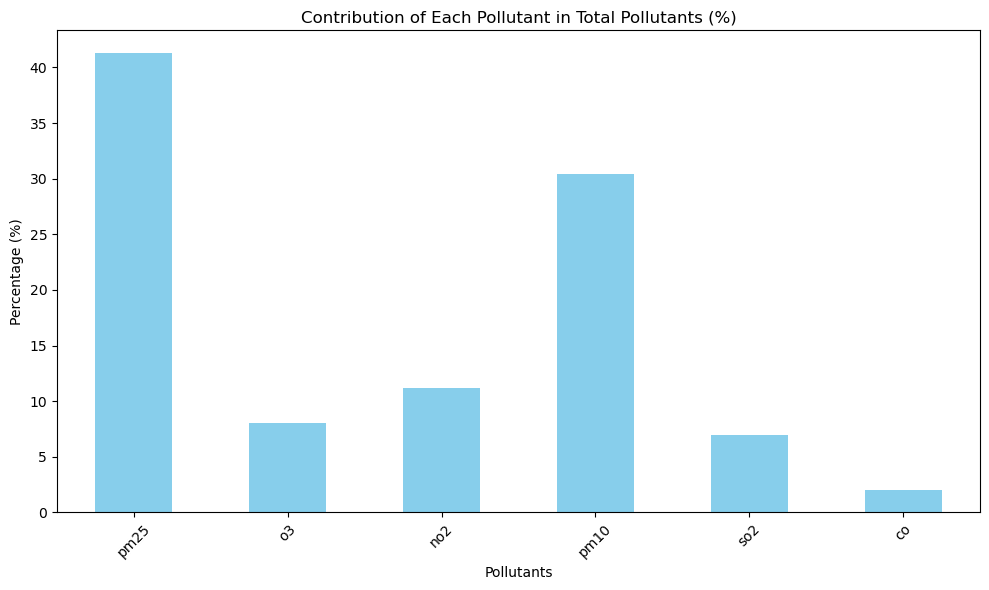

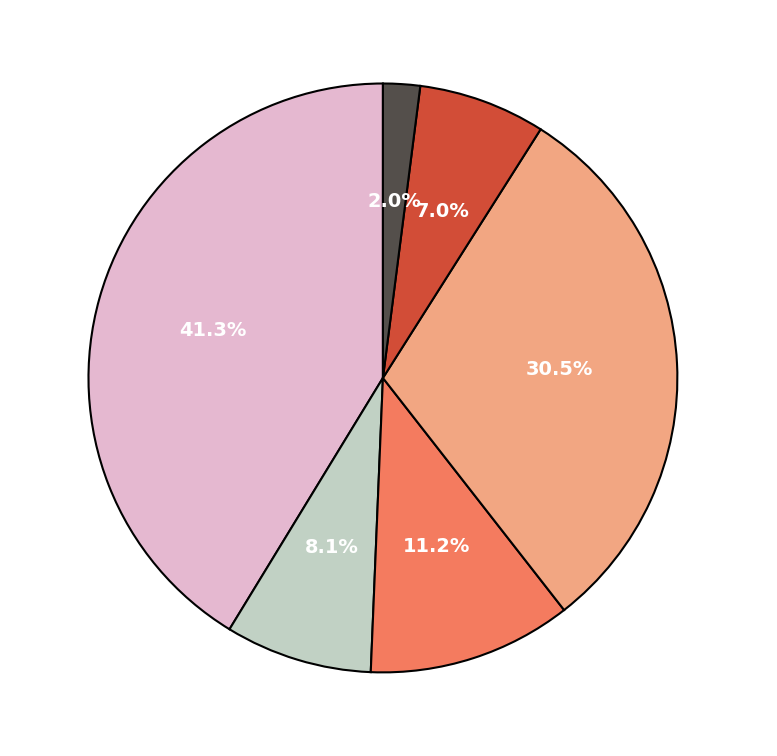

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt
import pandas as pd



# Let's reload the most recent CSV file to calculate the contribution of each pollutant.
file_path_csv = 'GIS_DataAQI.csv'

# Load data
df = pd.read_csv(file_path_csv)

# List of the 6 pollutants
pollutants_columns = ['pm25', 'o3', 'no2', 'pm10', 'so2', 'co']

# Calculate the total sum of the values for these pollutants
pollutants_sum = df[pollutants_columns].sum()

# Normalize the values to get the percentage contribution (out of 100%)
pollutants_percentage = (pollutants_sum / pollutants_sum.sum()) * 100

# Create a bar chart to visualize the percentage contribution of each pollutant
plt.figure(figsize=(10,6))
pollutants_percentage.plot(kind='bar', color='skyblue')
plt.title('Contribution of Each Pollutant in Total Pollutants (%)')
plt.ylabel('Percentage (%)')
plt.xlabel('Pollutants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Adding a legend on the right side of the pie chart to represent the pollutants
plt.figure(figsize=(10, 8))

# Plot the pie chart with legend and improved styling
pollutants_percentage.plot(kind='pie', 
                            autopct='%1.1f%%', 
                            startangle=90, 
                            colors=pie_colors, 
                            wedgeprops={'edgecolor': 'black', 'linewidth': 1.5, 'linestyle': 'solid'},
                            textprops={'color': 'white', 'fontsize': 14, 'weight': 'bold'})

# Title and layout adjustments
plt.title('Biểu đồ thể hiện tầm quan trọng của các đặc trung', fontsize=16, weight='bold', color='black')
plt.ylabel('')  # Removing the y-label for a cleaner look

# Add a legend on the right side
plt.legend(labels=pollutants_percentage.index, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Chất ô nhiễm")

plt.tight_layout()  # Adjust layout

# Show the plot
plt.show()



